In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
from datetime import datetime
import os,sys

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [208]:
import tensorflow as tf
from keras.layers import (
    Input,
    LSTM,
    Dropout,
    Dense
)
from keras.models import (
    Model,
    Sequential,
    load_model
)
from tensorflow.keras.callbacks import (
    Callback,
    TensorBoard,
    EarlyStopping
)

In [209]:
def locate_input_file(input_file_name="gold_price_2013_2023.csv"):
    try:
        dir_name=os.getcwd()
        input_file_path=os.path.join(dir_name,input_file_name)
        # print(input_file_path)
        return input_file_path
    
    except Exception as e:
        print(f"error : {e}")

In [210]:
def get_input_data(file_path):
    
    try:
        df=pd.read_csv(file_path)
        return df
    
    except Exception as e:
        print(f"error : {e}")



In [211]:
def print_details(df):
    try:
        print(f"shape of df : {df.shape}\n")
        print(f"columns of df : {df.columns}\n\n")
        print(f"information about df : \n{df.info()}\n\n")
        print(f"description about df : \n{df.describe()}\n\n")
        print(f"head of df : \n{df.head()}\n\n")
        print(f"tail of df : \n{df.tail()}\n\n")

        for col in df.columns:    
            print(f"value count of df : \n {df[col].value_counts()}")    

    except Exception as e:
        print(f"error : {e}")

In [212]:
def remove_unwanted_columns(df,unwanted_columns):
    try:
        # unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        unwanted_count=len(unwanted_columns)
        # print(unwanted_count)
        temp_count=0
        for col in unwanted_columns:
            if col in df.columns:
                temp_count+=1

        
        if temp_count==unwanted_count :
            print(f"all unwanted columns can be removed.")
        else:
            print(f"all unwanted columns can not be removed.")

        df=df.drop(columns=unwanted_columns,axis=1)

        return df
    
    except Exception as e:
        print(f"error : {e}")

In [213]:
def sort_date(df):
    try:
        df.sort_values(
            by=["Date"],
            axis=0,
            ascending=True,
            inplace=True
        )
        return df

    except Exception as e:
        print(f"error : {e}")

In [214]:
def clean_data(df):
    try:
        df["Date"]=pd.to_datetime(df["Date"])
        df["Price"]=df["Price"].str.replace(",","").astype(float)
        df=sort_date(df)

        return df

    except Exception as e:
        print(f"error : {e}")

In [215]:
def handle_missing(df):
    try:
        print(f"Column-wise missing values:\n{df.isnull().sum()}\n")
        print(f"Total missing values: {df.isnull().sum().sum()}\n")

        num_cols = df.select_dtypes(include=["int64", "float64"]).columns
        cat_cols = df.select_dtypes(include="object").columns

        print(f"Numerical columns: {list(num_cols)}")
        print(f"Categorical columns: {list(cat_cols)}")

        # Fill missing values
        for col in num_cols:
            df[col] = df[col].fillna(df[col].mean())

        for col in cat_cols:
            df[col] = df[col].fillna(df[col].mode()[0])

        return df

    except Exception as e:
        print("Error:", e)


In [216]:
def handle_duplicate(df):
    try:
        duplicate_count=df.duplicated().sum()
        print(f"duplicated  values : {duplicate_count}")
        
        if duplicate_count>0:
            df.drop_duplicates(ignore_index=True)

        return df

    except Exception as e:
        print(e)

In [217]:
def plot_figure(df):
    try:
        test_size=df[df["Date"].dt.year==2022].shape[0]
            
        plt.figure(
            figsize=(15,6),
            dpi=150
        )
        plt.rcParams["axes.facecolor"] = "pink"
        plt.rcParams["axes.edgecolor"] = "white"
        
        plt.plot(
            df["Date"][:-test_size],
            df["Price"][:-test_size],
            color="blue",
            lw=2        
        )
        plt.plot(
            df["Date"][-test_size:],
            df["Price"][-test_size:],
            color="yellow",
            lw=2
        )
        plt.title("gold price",fontsize=36)
        plt.xlabel("Date",fontsize=12)
        plt.ylabel("Price",fontsize=12)
        plt.legend(
            [
                "Training set",
                "Test set"
            ],
            loc="upper left",
            prop={"size":15}
        )
        plt.grid(color="white")
        plt.show()

    except Exception as e:
        print(f"error  : {e}")

In [218]:
def build_train_test_dataset(df,test_size,window):
    try:
        train_data=df["Price"][:-test_size].to_numpy().reshape(-1,1)
        x_train=[]
        y_train=[]

        for i in range(window,len(train_data)):
            x_train.append(train_data[i-window:i,0])
            y_train.append(train_data[i,0])


        x_train=np.array(x_train)
        y_train=np.array(y_train)

        print(f"x_train shape :{x_train.shape}")
        print(f"y_train shape :{y_train.shape}")


        
        test_data=df["Price"][-test_size-60:].to_numpy().reshape(-1,1)
        x_test=[]
        y_test=[]

        for i in range(window,len(test_data)):
            x_test.append(test_data[i-window:i,0])
            y_test.append(test_data[i,0])

        x_test=np.array(x_test)
        y_test=np.array(y_test)


        print(f"x_test shape :{x_test.shape}")
        print(f"y_test shape :{y_test.shape}")


        return x_train,y_train,x_test,y_test

    except Exception as e:
        print(f"error : {e}")

In [219]:
def get_recent_log_dir():
    try:
        log_path = os.path.join(os.getcwd(), "log","fit")
        log_files = sorted(os.listdir(log_path))
        return os.path.join(log_path, log_files[-1])

    except Exception as e:
        print(f"error : {e}")

def launch_tensorboard():
    try:
        ipython = get_ipython()

        # Load or reload the extension
        try:
            ipython.run_line_magic('reload_ext', 'tensorboard')
        except:
            ipython.run_line_magic('load_ext', 'tensorboard')

        # Get latest log directory
        log_dir = get_recent_log_dir()
        print("Launching TensorBoard at:", log_dir)

        # Start TensorBoard
        ipython.run_line_magic('tensorboard', f'--logdir "{log_dir}"')

    except Exception as e:
        print(f"error : {e}")

In [220]:
def get_tensorboard_callback():
    try:
        tensor_file_name=datetime.now().strftime("%d_%m_%y__%H_%M_%S")
        log_file= "log"

        log_path=os.path.join(os.getcwd(),log_file,"fit",tensor_file_name)
        dir_name=os.path.dirname(log_path)
        
        os.makedirs(
            dir_name,
            exist_ok=True
        )

        # return TensorBoard(
        #         log_dir=log_path,
        #         histogram_freq=1
        # )


        return TensorBoard(
            log_dir=log_path,
            histogram_freq=1,
            write_graph=True,
            write_images=True,
            profile_batch=0  # Set to 0 or specific batch index for profiling
        )
    
    except Exception as e:
        print(f"error : {e}")

In [221]:
def get_early_stopping_callback():
    try :
        early_stopping_callback=EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
        )
        return  early_stopping_callback

    except Exception as e:
        print(f"error : {e}")

In [222]:
def build_model(window):
    try:
        input1=Input(shape=(window,1))
        x=LSTM( 
            units=64,
            return_sequences=True
        )(input1)
        x=Dropout(.2)(x)
        x=LSTM(
            units=64,
            return_sequences=True
        )(x)
        x=Dropout(0.2)(x)
        x=LSTM(
            units=64,
            return_sequences=False
        )(x)
        x=Dropout(.2)(x)
        x=Dense(
            units=32,
            activation="softmax"
        )(x)
        dnn_output=Dense(1)(x)


        model=Model(
            inputs=input1,
            outputs=[dnn_output]
        )
        model.compile(
            loss="mean_squared_error",
            optimizer="Nadam"
        )
        model.summary()

        return model
    

    except Exception as e:
        print(f"error : e")

In [223]:
def compile_model(model):
    try:
        model.compile(
            optimizer="adam",
            loss="mae",
            metrics=["mae","mse"]
        )

        return model

    except Exception as e:
        print("error : {e}")

In [224]:
def run_model(model,x_train,y_train,epochs):
    try:
        start_time=datetime.now()
        history=model.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=32,
            validation_split=0.2,
            verbose=1,
            callbacks=[
                get_tensorboard_callback(),
                get_early_stopping_callback()
            ]
        )
        end_time=datetime.now()

        print(f"time taken to run the model : {end_time - start_time}")

        return history

    except Exception as e:
        print(f"error : {e}")

In [225]:
# def evaluate_history(history):
#     try:
#         history_data = history.history
#         keys = list(history_data.keys())

#         plt.figure(figsize=(10, 6))
#         plt.title("Model Training Metrics")
#         plt.xlabel("Epoch")
#         plt.ylabel("Metric Value")

#         for key in keys:
#             plt.plot(history_data[key], label=key)

#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#     except Exception as e:
#         print(f"History evaluation error: {e}")


In [226]:
def show_history(history):
    try:
        history_data = history.history
        keys = list(history_data.keys())
        
        validation_keys=[k for k in keys if k.startswith("val_")]
        training_keys=[k for k in keys if not k.startswith("val_") ]

        for key in keys:
            plt.figure(figsize=(5, 3))
            plt.xlabel("Epoch")
            plt.ylabel(f"{key}")
            plt.plot(history_data[key], label=key)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        for key1,key2 in zip(training_keys,validation_keys):
            plt.figure(figsize=(5, 3))
            plt.xlabel("Epoch")
            # plt.ylabel(f"{key}")
            plt.plot(history_data[key1], label=key1)
            plt.plot(history_data[key2], label=key2)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            

    except Exception as e:
        print(f"History evaluation error: {e}")


In [227]:
# 

In [228]:
def save_history_csv(history, file_path):
    try:
        df = pd.DataFrame(history.history)
        df.to_csv(file_path, index=False)
        
        print(f"History saved as CSV at {file_path}")
    except Exception as e:
        print(f"Error saving history as CSV: {e}")


In [229]:
def history_details(history):
    try:
        file_name=datetime.now().strftime("history%d_%m_%y__%Hh_%Mm_%Ss")+".csv"
        file_path=os.path.join(os.getcwd(),"history",file_name)
        file_dir=os.path.dirname(file_path)
        os.makedirs(
            file_dir,
            exist_ok=True
        )

        save_history_csv(history,file_path)
        show_history(history)
            

    except Exception as e:
        print(f"History evaluation error: {e}")


In [230]:
def evaluate_model():
    try:
        # evaluate_history()
        launch_tensorboard()

    except Exception as e:
        print(f"error : {e}")

In [231]:
def run_training():
    try:
        input_file_path=locate_input_file()
        print(input_file_path)  


        df=get_input_data(input_file_path)
        print_details(df)

        unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        df=remove_unwanted_columns(df,unwanted_columns)
        print_details(df)

        df=clean_data(df)
        print(df.head())
        print(df.tail())
        

        df=handle_missing(df)

        df=handle_duplicate(df)

        plot_figure(df)


        test_size=df[df["Date"].dt.year==2022].shape[0]
        window=60

        print(test_size,window)


        x_train,y_train,x_test,y_test=build_train_test_dataset(
            df,
            test_size,
            window
        )

        model=build_model(window)

        model=compile_model(model)

        model_file_name=f"model_{window}_.h5"
        model.save(model_file_name)

        epochs=50

        history=run_model(
            model,
            x_train,
            y_train,
            epochs
        )

        history_details(history)

        evaluate_model()




    except Exception as e:
        print(f"error : {e}")

e:\data_science_play_ground\gold_price_prediction\gold_price_2013_2023.csv
shape of df : (2583, 7)

columns of df : Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB
information about df : 
None


description about df : 
              Date     Price      Open      High       Low   Vol. Change %
count         2583      2583      2583      2583      2583   2578     2583
unique        2583      2072      2061      2044      2019   1550      474
top     12/30/2022  1,294.30

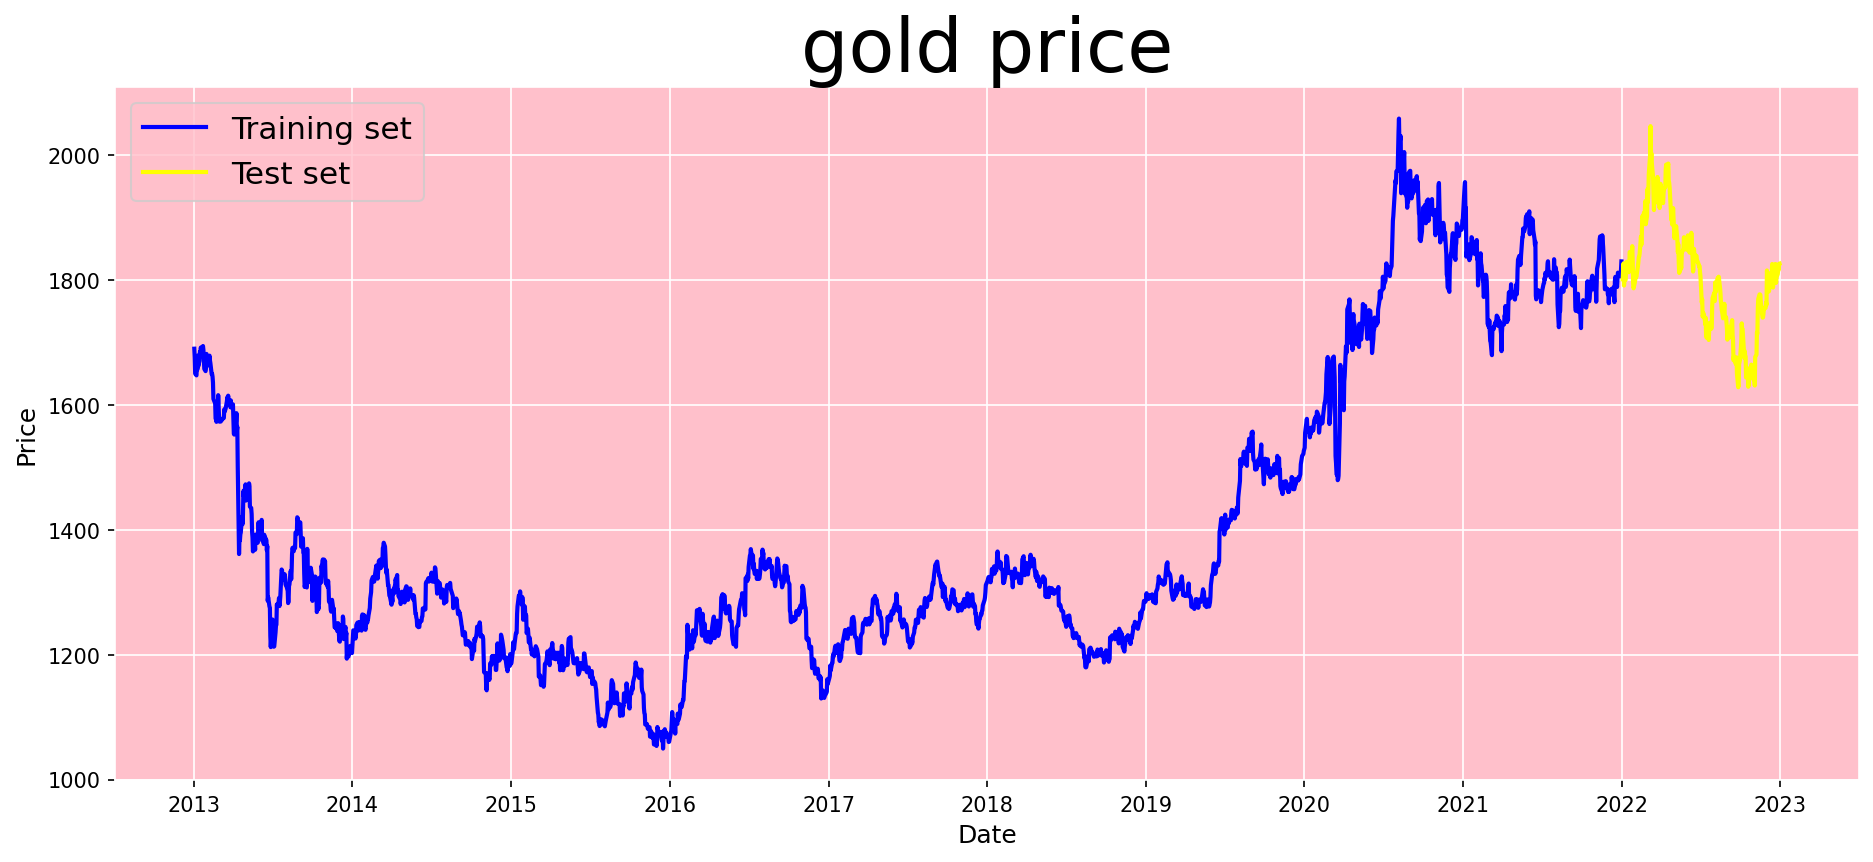

260 60
x_train shape :(2263, 60)
y_train shape :(2263,)
x_test shape :(260, 60)
y_test shape :(260,)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1286.8057 - mae: 1286.8057 - mse: 1668246.7500 - val_loss: 1817.1803 - val_mae: 1817.1803 - val_mse: 3307856.5000
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1286.5918 - mae: 1286.5918 - mse: 1667697.1250 - val_loss: 1817.0590 - val_mae: 1817.0590 - val_mse: 3307415.7500
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1286.4725 - mae: 1286.4725 - mse: 1667390.0000 - val_loss: 1816.9413 - val_mae: 1816.9413 - val_mse: 3306987.0000
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1286.3555 - mae: 1286.3555 - mse: 1667088.1250 - val_loss: 1816.8242 - val_mae: 1816.8242 - val_mse: 3306563.2500
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1286.2389 - mae: 1286.2389 - mse: 1666788.8750 - val_loss: 1816.7084 - val_mae: 1816.7084 - val_mse: 3306141.7500
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1286.1230 - mae: 1286.1230 - mse: 1666491.3750 - val_loss: 1816.5930 - val_m

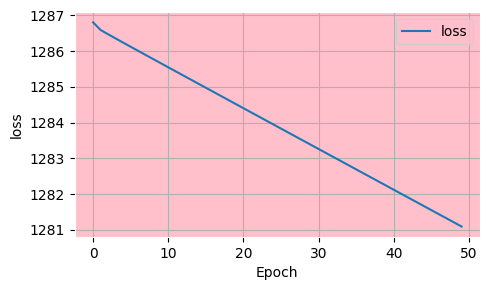

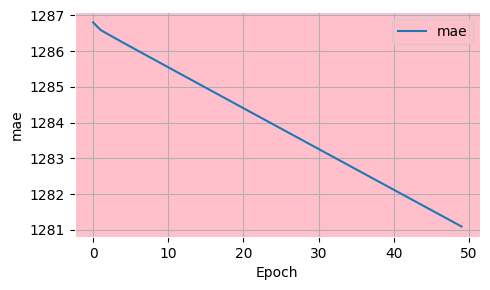

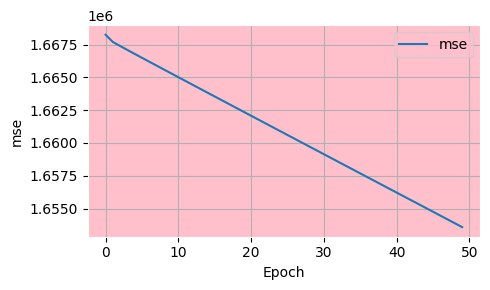

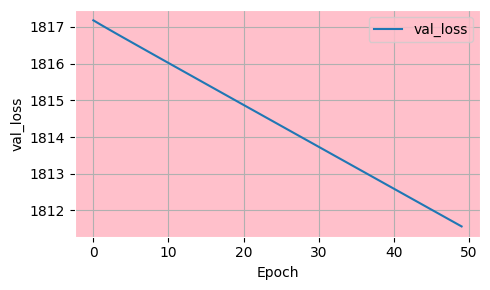

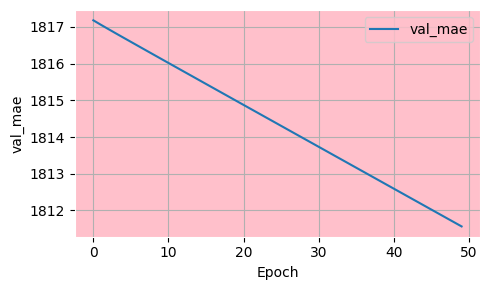

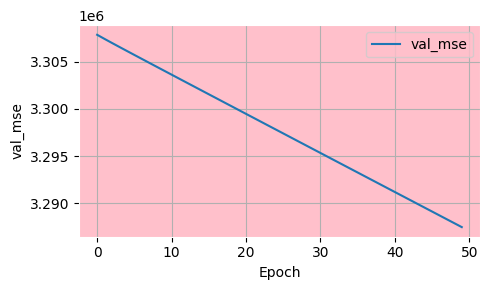

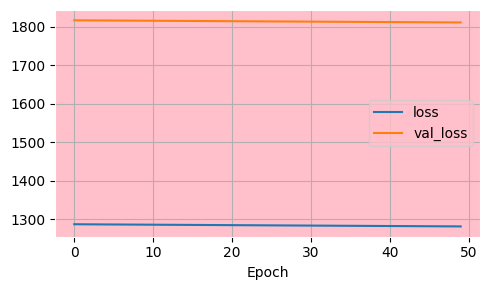

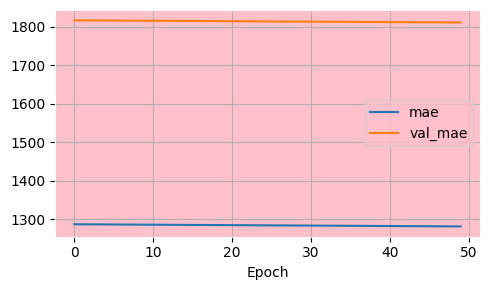

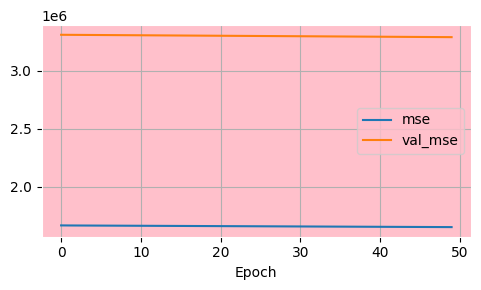

Launching TensorBoard at: e:\data_science_play_ground\gold_price_prediction\log\fit\05_09_25__12_07_05


In [232]:
run_training()

In [233]:
# history_details(history)